In [21]:
import pandas as pd
import matplotlib.pylab as plt
import re
from itertools import cycle

pd.set_option("display.max_columns", 500)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])


In [22]:
tweets = pd.read_csv("tweets.csv")

In [23]:
def process_tweets(tweets):
    tweets['tweet_date'] = pd.to_datetime(tweets['tweet_date']).dt.date
    tweets['wordle_id'] = tweets['tweet_text'].str[:10]
    tweets["n_attempts"] = tweets['tweet_text'].str[11].astype(int)
    tweets["id"] = tweets['tweet_text'].str[7:10].astype(int)
    return tweets

tweets = process_tweets(tweets)

### How many tweets per day?

In [24]:
tweets["tweet_date"].value_counts().sort_index()

tweet_date
2022-01-16     2730
2022-01-17     2830
2022-01-18     2365
2022-01-19     2121
2022-01-20     2694
2022-01-21     6230
2022-01-22     2921
2022-01-23     6549
2022-01-24     2930
2022-01-25     3337
2022-01-26     6634
2022-01-27     6747
2022-01-28    15937
2022-01-29     6628
2022-01-30     7017
2022-01-31     6402
2022-02-01     6465
2022-02-02     6621
2022-02-03     6059
2022-02-04     6570
2022-02-05     6790
2022-02-06     7709
2022-02-07     3198
2022-02-08     6309
2022-02-09     6380
2022-02-10     6623
2022-02-11    13403
2022-02-12     6950
2022-02-13     3580
2022-02-14     8291
2022-02-15    10032
2022-02-16     3222
2022-02-17     2772
2022-02-18     3357
2022-02-19     2933
2022-02-20     3328
2022-02-21     3520
2022-02-23     6746
2022-02-24     6550
2022-02-25     9598
2022-02-26     3108
Name: count, dtype: int64

<Axes: title={'center': 'Tweets per Day'}, xlabel='tweet_date'>

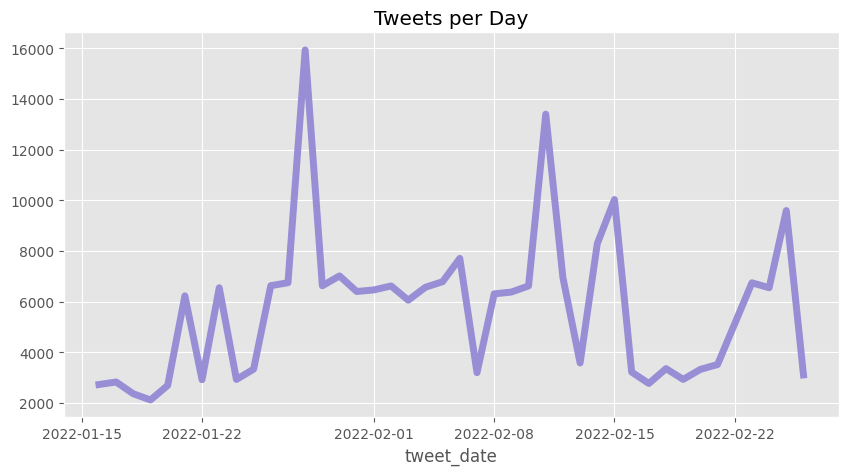

In [25]:
tweets["tweet_date"].value_counts().sort_index() \
    .plot(figsize=(10, 5), title="Tweets per Day",
          color=color_pal[2], lw=5)

### Number of Attempts

In [26]:
tweets.groupby('wordle_id')['n_attempts'].value_counts().unstack().style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
Wordle 210,222,897,1064,489,165
Wordle 211,196,903,1016,564,215
Wordle 212,191,787,820,413,188
Wordle 213,51,260,630,697,481
Wordle 214,383,1012,823,363,122
Wordle 215,246,877,1017,579,224
Wordle 216,461,1952,2078,1199,415
Wordle 217,102,566,1031,843,418
Wordle 218,170,1009,1384,730,187


### How many attempts to solve on average?


Text(0, 0.5, 'Number of guesses')

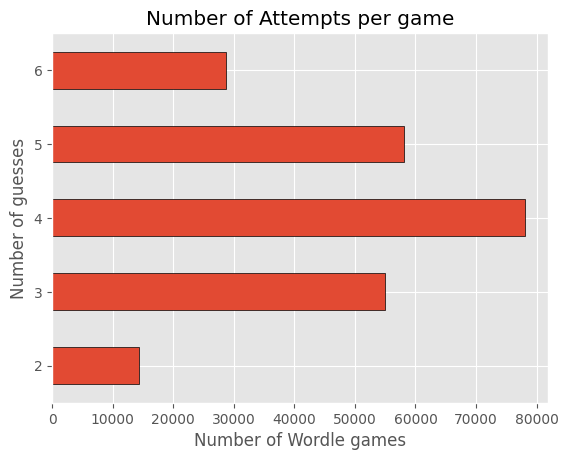

In [27]:
ax = tweets["n_attempts"].value_counts() \
    .sort_index() \
    .plot(kind="barh", title="Number of Attempts per game", edgecolor="black")
ax.set_xlabel("Number of Wordle games")
ax.set_ylabel("Number of guesses")



### Parse Tweet Text

In [28]:
# Make missed squares consistent
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜','⬛')


In [29]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1
        tweets[f'has_guess{n}'] = tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        # Parse out the tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n + 1].str[:5]
        # Count number correct, misplaced, and incorrect
        tweets.loc[tweets[f'has_guess{n}'],
                       f'guess{n}_incorrect'] = tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_wrong_spot'] = tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'],
                   f'guess{n}_correct'] = tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct'] == 6, 'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)


/var/folders/_w/p__mh4fn0pj6hdp6rksxkw9r0000gn/T/ipykernel_83625/4180829706.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
/var/folders/_w/p__mh4fn0pj6hdp6rksxkw9r0000gn/T/ipykernel_83625/4180829706.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
/var/folders/_w/p__mh4fn0pj6hdp6rksxkw9r0000gn/T/ipykernel_83625/4180829706.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the fut

In [30]:
# Keep additional tweet text
tweets['additional_text'] = \
    tweets.loc[~tweets['tweet_text'] \
    .str.split('\n').str[-1].str.contains('🟩')] \
    ['tweet_text'].str.split('\n').str[-1]

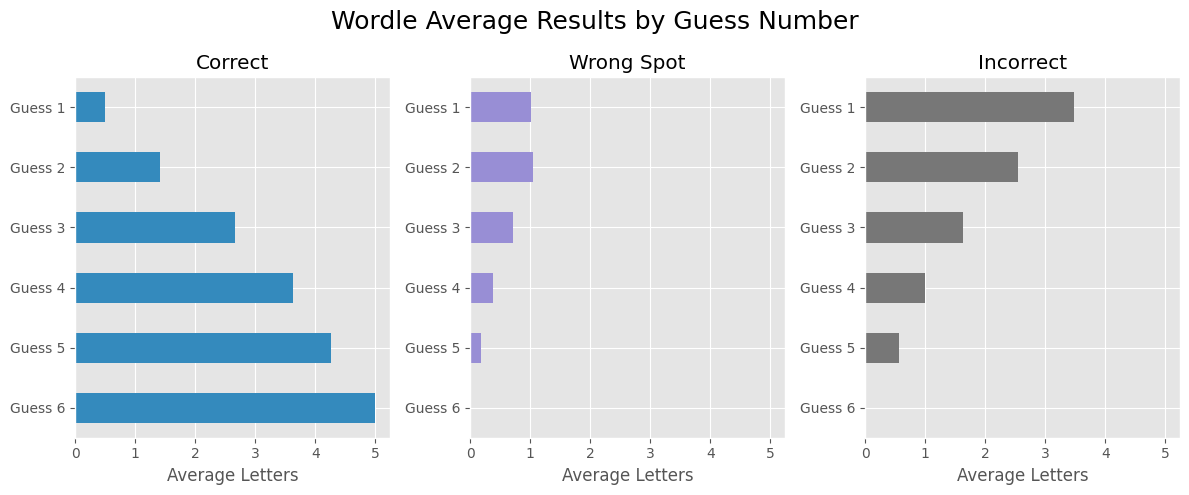

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for i, x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=axs[i],
              color=color_pal[i+1])
    axs[i].set_xlabel('Average Letters')
fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()

### Letter Analysis
What's the most common first letter of a word to guess correctly?

In [32]:
# gathered from 3rd party website
answer_dict = {
     252 : 'SPILL',
     251 : 'VIVID',
     250 : 'BLOKE',
     249 : 'TROVE',
     248 : 'THORN',
     247 : 'OTHER',
     246 : 'TACIT',
     245 : 'SWILL',
     244 : 'DODGE',
     243 : 'SHAKE',
     242 : 'CAULK',
     241 : 'AROMA',
     240 : 'CYNIC',
     239 : 'ROBIN',
     238 : 'ULTRA',
     237 : 'ULCER',
     236 : 'PAUSE',
     235 : 'HUMOR',
     234 : 'FRAME',
     233 : 'ELDER',
     232 : 'SKILL',
     231 : 'ALOFT',
     230 : 'PLEAT',
     229 : 'SHARD',
     228 : 'MOIST',
     227 : 'THOSE',
     204 : 'GORGE',
     205 : 'QUERY',
     206 : 'DRINK',
     207 : 'FAVOR',
     208 : 'ABBEY',
     209 : 'TANGY',
     210 : 'PANIC',
     211 : 'SOLAR',
     212 : 'SHIRE',
     213 : 'PROXY',
     214 : 'POINT',
     215 : 'ROBOT',
     216 : 'PRICK',
     217 : 'WINCE',
     218 : 'CRIMP',
     219 : 'KNOLL',
     220 : 'SUGAR',
     221 : 'WHACK',
     222 : 'MOUNT',
     223 : 'PERKY',
     224 : 'COULD',
     225 : 'WRUNG',
     226 : 'LIGHT',
}

tweets['answer'] = tweets['id'].map(answer_dict)

In [33]:
first_guess_correct = []
for i, d in tweets.dropna(subset=['answer']).iterrows():
    example_text = d['guess1']
    example_solution = d['answer']
    results =[x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct += first_guess_letters

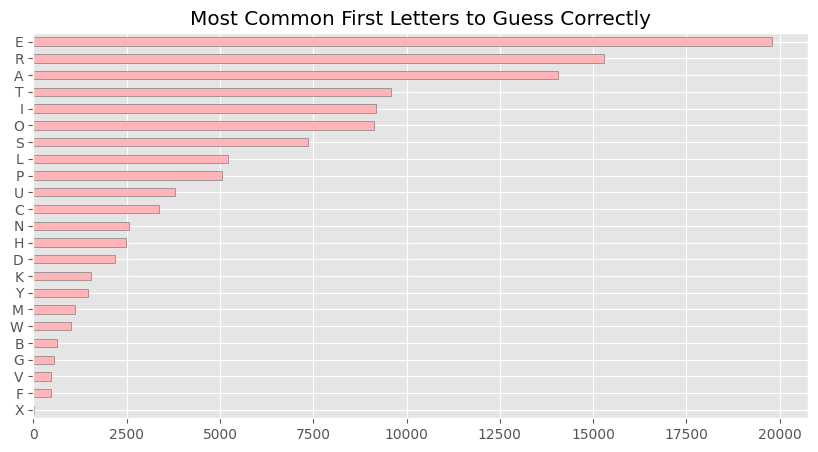

In [34]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10, 5),
         title='Most Common First Letters to Guess Correctly',
         edgecolor='gray', color=color_pal[6])
plt.show()